In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import humanize
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
%aimport allel.model
%aimport allel.stats
%aimport allel.plot
%aimport allel.opt.stats

In [2]:
gn = np.array([[0, 0, 1, 0, 2, 0, 1, 1, 0],
               [1, 0, 0, 1, 1, 2, 0, 0, 2]], dtype='i1')

In [3]:
np.corrcoef(gn)

array([[ 1.        , -0.39000675],
       [-0.39000675,  1.        ]])

In [4]:
gn_sq = gn ** 2

In [5]:
allel.opt.stats.gn_corrcoef_int8(gn[0], gn[1], gn_sq[0], gn_sq[1])

-0.39000681042671204

In [6]:
gnb = np.random.randint(0, 3, size=(2, 10000)).astype('i1')

In [7]:
np.corrcoef(gnb)

array([[ 1.      , -0.002613],
       [-0.002613,  1.      ]])

In [8]:
gnb_sq = gnb ** 2

In [9]:
allel.opt.stats.gn_corrcoef_int8(gnb[0], gnb[1], gnb_sq[0], gnb_sq[1])

-0.002613014541566372

In [10]:
%timeit np.corrcoef(gnb)

10000 loops, best of 3: 127 µs per loop


In [11]:
%timeit allel.opt.stats.gn_corrcoef_int8(gnb[0], gnb[1], gnb_sq[0], gnb_sq[1])

10000 loops, best of 3: 40.9 µs per loop


In [12]:
gnb2 = np.random.randint(0, 3, size=(1000, 1000)).astype('i1')

In [13]:
r2a = np.corrcoef(gnb2)
r2a

array([[ 1.        , -0.05577752,  0.00767298, ..., -0.03381146,
         0.02954236, -0.00755626],
       [-0.05577752,  1.        , -0.02363069, ...,  0.02232033,
         0.06444761,  0.03827147],
       [ 0.00767298, -0.02363069,  1.        , ..., -0.02565621,
         0.00159606,  0.01190215],
       ..., 
       [-0.03381146,  0.02232033, -0.02565621, ...,  1.        ,
        -0.01959978, -0.00503218],
       [ 0.02954236,  0.06444761,  0.00159606, ..., -0.01959978,
         1.        , -0.0092057 ],
       [-0.00755626,  0.03827147,  0.01190215, ..., -0.00503218,
        -0.0092057 ,  1.        ]])

In [14]:
r2b = allel.stats.rogers_huff_r(gnb2)
from scipy.spatial.distance import squareform
r2b_sq = squareform(r2b)
r2b_sq

array([[ 0.        , -0.05577756,  0.00767297, ..., -0.03381132,
         0.02954236, -0.00755618],
       [-0.05577756,  0.        , -0.02363073, ...,  0.02232023,
         0.06444771,  0.03827157],
       [ 0.00767297, -0.02363073,  0.        , ..., -0.02565622,
         0.00159614,  0.01190209],
       ..., 
       [-0.03381132,  0.02232023, -0.02565622, ...,  0.        ,
        -0.01959965, -0.00503222],
       [ 0.02954236,  0.06444771,  0.00159614, ..., -0.01959965,
         0.        , -0.00920562],
       [-0.00755618,  0.03827157,  0.01190209, ..., -0.00503222,
        -0.00920562,  0.        ]])

In [15]:
%timeit np.corrcoef(gnb2)
%memit np.corrcoef(gnb2)

10 loops, best of 3: 123 ms per loop
peak memory: 118.31 MiB, increment: 15.11 MiB


In [16]:
%timeit allel.stats.rogers_huff_r(gnb2)
%memit allel.stats.rogers_huff_r(gnb2)

1 loops, best of 3: 1.95 s per loop
peak memory: 103.39 MiB, increment: 0.00 MiB


In [17]:
import cProfile

In [18]:
cProfile.run('allel.stats.rogers_huff_r(gnb2)', sort='time')

         13 function calls in 2.090 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.090    2.090    2.090    2.090 {allel.opt.stats.gn_pairwise_corrcoef_int8}
        2    0.000    0.000    0.000    0.000 numeric.py:394(asarray)
        1    0.000    0.000    2.090    2.090 {built-in method exec}
        1    0.000    0.000    2.090    2.090 ld.py:12(rogers_huff_r)
        2    0.000    0.000    0.000    0.000 {built-in method array}
        1    0.000    0.000    0.000    0.000 util.py:20(asarray_ndim)
        1    0.000    0.000    2.090    2.090 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:2264(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 {built-in method hasattr}
        1    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



##LD pruning 

In [19]:
import random
import numpy as np

def simulate_genotypes_with_ld(n_variants, n_samples, correlation=0.2):
    """A very simple function to simulate a set of genotypes, where
    variants are in some degree of linkage disequilibrium with their
    neighbours.

    Parameters
    ----------

    n_variants : int
        The number of variants to simulate data for.
    n_samples : int
        The number of individuals to simulate data for.
    correlation : float, optional
        The fraction of samples to copy genotypes between neighbouring
        variants.

    Returns
    -------

    gn : ndarray, int8
        A 2-dimensional array of shape (n_variants, n_samples) where each
        element is a genotype call coded as a single integer counting the
        number of non-reference alleles.

    """

    # initialise an array of random genotypes
    gn = np.random.randint(size=(n_variants, n_samples), low=0, high=3)
    gn = gn.astype('i1')

    # determine the number of samples to copy genotypes for
    n_copy = int(correlation * n_samples)

    # introduce linkage disequilibrium by copying genotypes from one sample to
    # the next
    for i in range(1, n_variants):

        # randomly pick the samples to copy from
        sample_indices = random.sample(range(n_samples), n_copy)

        # view genotypes from the previous variant for the selected samples
        c = gn[i-1, sample_indices]

        # randomly choose whether to invert the correlation
        inv = random.randint(0, 1)
        if inv:
            c = 2-c

        # copy across genotypes
        gn[i, sample_indices] = c

    return gn


In [20]:
gnl = simulate_genotypes_with_ld(1000, 1000, .97)
gnl.shape

(1000, 1000)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
x = allel.stats.rogers_huff_r(gnl) ** 2

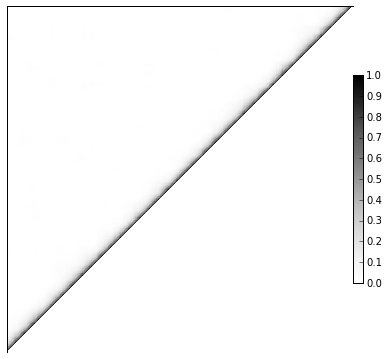

In [23]:
allel.plot.pairwise_ld(x);

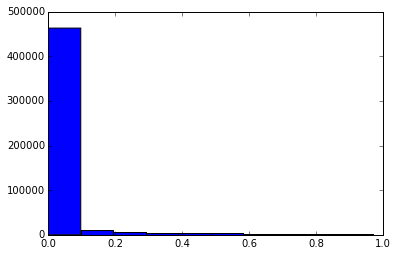

In [24]:
plt.hist(x);

In [25]:
loc = allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.4)

In [26]:
np.count_nonzero(loc)

65

In [27]:
np.nonzero(loc)[0]

array([  0,  17,  32,  47,  63,  79,  95, 110, 124, 138, 156, 171, 186,
       202, 217, 233, 249, 265, 283, 298, 314, 330, 346, 360, 375, 390,
       404, 418, 435, 449, 464, 480, 494, 510, 526, 541, 555, 567, 584,
       599, 618, 633, 648, 663, 677, 692, 709, 726, 743, 759, 773, 787,
       802, 819, 834, 848, 863, 879, 894, 909, 924, 942, 957, 972, 987])

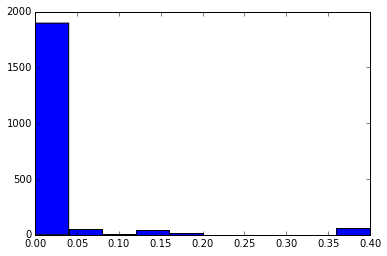

In [28]:
gnu = gnl[loc]
y = allel.stats.rogers_huff_r(gnu) ** 2
plt.hist(y);

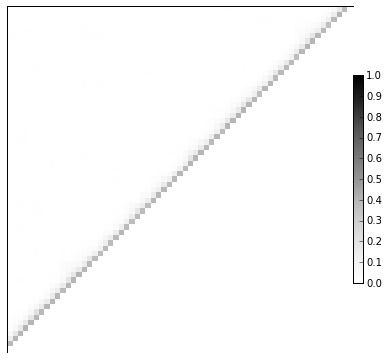

In [29]:
x = allel.stats.rogers_huff_r(gnu) ** 2
allel.plot.pairwise_ld(x);

In [30]:
%timeit allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.3)
%memit allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.3)

10 loops, best of 3: 37.9 ms per loop
peak memory: 135.96 MiB, increment: 0.01 MiB


In [31]:
import cProfile
cProfile.run('allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.3)', sort='time')

         16 function calls in 0.044 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.043    0.043    0.044    0.044 {allel.opt.stats.gn_locate_unlinked_int8}
        1    0.000    0.000    0.044    0.044 {built-in method exec}
        2    0.000    0.000    0.000    0.000 {built-in method array}
        1    0.000    0.000    0.044    0.044 ld.py:106(locate_unlinked)
        1    0.000    0.000    0.000    0.000 util.py:20(asarray_ndim)
        2    0.000    0.000    0.000    0.000 numeric.py:394(asarray)
        1    0.000    0.000    0.000    0.000 {built-in method empty}
        1    0.000    0.000    0.000    0.000 {built-in method copyto}
        1    0.000    0.000    0.000    0.000 numeric.py:141(ones)
        1    0.000    0.000    0.044    0.044 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:2264(_handle_fromlist)
        1    0.000    0.000    0.000  